In [1]:
%matplotlib notebook
%matplotlib notebook
from pyvitools import *
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import glob
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['axes.grid'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

NO ROS MSGS
NO ROSBAG PARSING
NO CV BRIDGE


In [2]:
def plot_results(fname):
    x_t, y_t, z_t = list(), list(), list()
    x_e, y_e, z_e = list(), list(), list()
    with open(fname, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            x_t.append(float(row[0]))
            y_t.append(float(row[1]))
            z_t.append(float(row[2]))
            x_e.append(float(row[7]))
            y_e.append(float(row[8]))
            z_e.append(float(row[9]))
    ax = plt.axes(projection='3d')
    ax.plot3D(x_t,y_t,z_t,'k-')
    ax.plot3D(x_e,y_e,z_e,'r--')
    plt.show()
    
def plot_results_flat(fname):
    t = list()
    x_t, y_t, z_t = list(), list(), list()
    x_e, y_e, z_e = list(), list(), list()
    with open(fname, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            t.append(float(len(t)))
            x_t.append(float(row[0]))
            y_t.append(float(row[1]))
            z_t.append(float(row[2]))
            x_e.append(float(row[7]))
            y_e.append(float(row[8]))
            z_e.append(float(row[9]))
    fig, axs = plt.subplots(3,1)
    axs[0].plot(t, x_t, 'k-')
    axs[0].plot(t, x_e, 'r--')
    axs[1].plot(t, y_t, 'k-')
    axs[1].plot(t, y_e, 'r--')
    axs[2].plot(t, z_t, 'k-')
    axs[2].plot(t, z_e, 'r--')
    plt.show()
    
def animateDRPGOResults(logfile, title, cam_azimuth_deg=0.0, cam_elevation_deg=45.0, vidfile=None):
    animator = None
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow']
    with open(logfile, newline='') as csvf:
        reader = csv.reader(csvf, delimiter=',')
        true_poses = list()
        est_poses = list()
        anchor_idxs = list()
        t = 0
        for i, row in enumerate(reader):
            if i == 0:
                num_robots = int(row[0])
                max_comm_dist = float(row[1])
                x_l, x_u = float(row[2]), float(row[3])
                y_l, y_u = float(row[4]), float(row[5])
                z_l, z_u = float(row[6]), float(row[7])
                animator = Animator3D(title=title, xlim=[x_l,x_u], ylim=[y_l,y_u], zlim=[z_l,z_u], 
                                      show_ticks=False, show_grid=False, 
                                      camera_az_el_deg=(cam_azimuth_deg, cam_elevation_deg))
                continue
            if row[0] == 'T':
                if len(true_poses) > 0:
                    for j, (true_robot_poses, est_robot_poses) in enumerate(zip(true_poses, est_poses)):
                        true_x_hist = [T.t[0,0] for T in true_robot_poses]
                        true_y_hist = [T.t[1,0] for T in true_robot_poses]
                        true_z_hist = [T.t[2,0] for T in true_robot_poses]
                        est_x_hist = [T.t[0,0] for T in est_robot_poses]
                        est_y_hist = [T.t[1,0] for T in est_robot_poses]
                        est_z_hist = [T.t[2,0] for T in est_robot_poses]
                        animator.add(t, Plot3DLine(true_x_hist, true_y_hist, true_z_hist, color=colors[j], style='-.'))
                        animator.add(t, Plot3DLine(est_x_hist, est_y_hist, est_z_hist, color=colors[j], style='-', width=1.5))
                        animator.add(t, Plot3DFrame(true_robot_poses[-1], scale=0.5, width=2.0))

                        if j in anchor_idxs:
                            animator.add(t, Plot3DCircle(true_robot_poses[-1], scale=0.5, width=3.0))
                        j_pos = true_poses[j][-1].t
                        for k in range(j):
                            k_pos = true_poses[k][-1].t
                            if np.linalg.norm(j_pos-k_pos) <= max_comm_dist:
                                x_rg = [j_pos[0,0], k_pos[0,0]]
                                y_rg = [j_pos[1,0], k_pos[1,0]]
                                z_rg = [j_pos[2,0], k_pos[2,0]]
                                animator.add(t, Plot3DLine(x_rg, y_rg, z_rg, color='black', style=':'))
                    true_poses.clear()
                    est_poses.clear()
                t += 1
                anchor_idxs.clear()
                for i in range(int(row[2])):
                    anchor_idxs.append(int(row[3+i]))
            else:
                for j in range(num_robots):
                    if len(true_poses) < j+1:
                        true_poses.append(list())
                        est_poses.append(list())
                    true_poses[j].append(SE3.fromCSVRow(row, 14*j+0))
                    est_poses[j].append(SE3.fromCSVRow(row, 14*j+7))
    if not vidfile is None:
        animator.saveAnimationAsVideo(vidfile)
    animator.animate()
    
def SE3_RMSE(true_SE3_list, est_SE3_list):
    x_err, y_err, z_err, rx_err, ry_err, rz_err = \
        list(), list(), list(), list(), list(), list()
    for true_SE3, est_SE3 in zip(true_SE3_list, est_SE3_list):
        error = est_SE3 - true_SE3
        x_err.append(error[0,0])
        y_err.append(error[1,0])
        z_err.append(error[2,0])
        rx_err.append(error[3,0])
        ry_err.append(error[4,0])
        rz_err.append(error[5,0])
    return np.sqrt((np.array(x_err)**2).mean()), np.sqrt((np.array(y_err)**2).mean()), \
           np.sqrt((np.array(z_err)**2).mean()), np.sqrt((np.array(rx_err)**2).mean()), \
           np.sqrt((np.array(ry_err)**2).mean()), np.sqrt((np.array(rz_err)**2).mean())
    
def plot_RMSE_over_time(logdir, plotname='rmse.svg'):
    data = dict()
    for fulllogfile in glob.glob(os.path.join(logdir, '?_t*.csv')):
        logfile = os.path.basename(fulllogfile)
        r = int(logfile.split('_')[0])
        if not r in data:
            data[r] = dict()
        t = int(logfile.split('t')[1].split('.')[0])
        
        with open(fulllogfile, newline='') as csvf:
            reader = csv.reader(csvf, delimiter=',')
            true_SE3_list, est_SE3_list = list(), list()
            for row in reader:
                true_SE3_list.append(SE3.fromCSVRow(row))
                est_SE3_list.append(SE3.fromCSVRow(row, start_idx=7))
            
            data[r][t] = SE3_RMSE(true_SE3_list, est_SE3_list)
            
    colors = ['k-', 'r-', 'g-', 'b-']
            
    fig, axs = plt.subplots(2, 3)
            
    for r in sorted(data.keys()):
        iterations = list()
        x_rmse, y_rmse, z_rmse, rx_rmse, ry_rmse, rz_rmse = \
            list(), list(), list(), list(), list(), list()
        for t in sorted(data[r].keys()):
            x_r, y_r, z_r, rx_r, ry_r, rz_r = data[r][t]
            iterations.append(t)
            x_rmse.append(x_r)
            y_rmse.append(y_r)
            z_rmse.append(z_r)
            rx_rmse.append(rx_r)
            ry_rmse.append(ry_r)
            rz_rmse.append(rz_r)
            
        axs[0,0].plot(iterations, x_rmse, colors[r])
        axs[0,0].set_xlabel('Poses in Graph')
        axs[0,0].set_ylabel('$t_x$ RMSE (m)')
        axs[0,1].plot(iterations, y_rmse, colors[r])
        axs[0,1].set_xlabel('Poses in Graph')
        axs[0,1].set_ylabel('$t_y$ RMSE (m)')
        axs[0,2].plot(iterations, z_rmse, colors[r])
        axs[0,2].set_xlabel('Poses in Graph')
        axs[0,2].set_ylabel('$t_z$ RMSE (m)')
        axs[1,0].plot(iterations, rx_rmse, colors[r])
        axs[1,0].set_xlabel('Poses in Graph')
        axs[1,0].set_ylabel('$\\theta_x$ RMSE (rad)')
        axs[1,1].plot(iterations, ry_rmse, colors[r])
        axs[1,1].set_xlabel('Poses in Graph')
        axs[1,1].set_ylabel('$\\theta_y$ RMSE (rad)')
        axs[1,2].plot(iterations, rz_rmse, colors[r])
        axs[1,2].set_xlabel('Poses in Graph')
        axs[1,2].set_ylabel('$\\theta_z$ RMSE (rad)')
        
    plt.savefig(plotname)

def adjacent_indices(adjacency_graph, i):
    a_i = list()
    for idx_set in np.where(adjacency_graph[i,:]>0):
        a_i.extend(list(idx_set))
    return a_i

def plotDRPGOResults(logfile, plotname=None):
    colors = ['black', 'red', 'green', 'blue']
    cccolors = ['orange', 'purple', 'cyan', 'yellow']
    data = dict()
    anchors = dict()
    neighbors = dict()
    inv_neighbors = dict()
    with open(logfile, newline='') as csvf:
        reader = csv.reader(csvf, delimiter=',')
        true_poses = list()
        est_poses = list()
        t = 0
        for i, row in enumerate(reader):
            if i == 0:
                num_robots = int(row[0])
                for r in range(num_robots):
                    data[r] = dict()
                max_comm_dist = float(row[1])
                continue
            if row[0] == 'T':
                neighbors[t] = dict()
                inv_neighbors[t] = dict()
                comm_graph = np.eye(num_robots)
                if len(true_poses) > 0:
                    for j, (true_robot_poses, est_robot_poses) in enumerate(zip(true_poses, est_poses)):
                        data[j][t] = SE3_RMSE(true_robot_poses, est_robot_poses)
                        j_pos = true_poses[j][-1].t
                        for k in range(j):
                            k_pos = true_poses[k][-1].t
                            if np.linalg.norm(j_pos-k_pos) <= max_comm_dist:
                                comm_graph[j,k] = comm_graph[k,j] = 1.0
                    true_poses.clear()
                    est_poses.clear()
                explored = [False for i in range(num_robots)]
                numCC = 0
                for i in range(num_robots):
                    if not explored[i]:
                        numCC += 1
                        Q = [i]
                        while len(Q) > 0:
                            v = Q.pop(0)
                            if not numCC in inv_neighbors[t]:
                                inv_neighbors[t][numCC] = [v]
                                neighbors[t][v] = numCC
                            else:
                                if not v in inv_neighbors[t][numCC]:
                                    inv_neighbors[t][numCC].append(v)
                                    neighbors[t][v] = numCC
                            for w in adjacent_indices(comm_graph, v):
                                if not explored[w]:
                                    explored[w] = True
                                    Q.append(w)
                t += 1
                anchors[t] = list()
                for i in range(int(row[2])):
                    anchors[t].append(int(row[3+i]))
            else:
                for j in range(num_robots):
                    if len(true_poses) < j+1:
                        true_poses.append(list())
                        est_poses.append(list())
                    true_poses[j].append(SE3.fromCSVRow(row, 14*j+0))
                    est_poses[j].append(SE3.fromCSVRow(row, 14*j+7))
                    
    fig, axs = plt.subplots(2, 3)

    for r in sorted(data.keys()):
        iterations = list()
        x_rmse, y_rmse, z_rmse, rx_rmse, ry_rmse, rz_rmse = \
            list(), list(), list(), list(), list(), list()
        for t in sorted(data[r].keys()):
            x_r, y_r, z_r, rx_r, ry_r, rz_r = data[r][t]
            iterations.append(t)
            x_rmse.append(x_r)
            y_rmse.append(y_r)
            z_rmse.append(z_r)
            rx_rmse.append(rx_r)
            ry_rmse.append(ry_r)
            rz_rmse.append(rz_r)
            
        axs[0,0].plot(iterations, x_rmse, colors[r])
        axs[0,1].plot(iterations, y_rmse, colors[r])
        axs[0,2].plot(iterations, z_rmse, colors[r])
        axs[1,0].plot(iterations, rx_rmse, colors[r])
        axs[1,1].plot(iterations, ry_rmse, colors[r])
        axs[1,2].plot(iterations, rz_rmse, colors[r])
        
    axs[0,0].set_xlabel('Poses in Graph')
    axs[0,0].set_ylabel('$t_x$ RMSE (m)')
    axs[0,1].set_xlabel('Poses in Graph')
    axs[0,1].set_ylabel('$t_y$ RMSE (m)')
    axs[0,2].set_xlabel('Poses in Graph')
    axs[0,2].set_ylabel('$t_z$ RMSE (m)')
    axs[1,0].set_xlabel('Poses in Graph')
    axs[1,0].set_ylabel('$\\theta_x$ RMSE (rad)')
    axs[1,1].set_xlabel('Poses in Graph')
    axs[1,1].set_ylabel('$\\theta_y$ RMSE (rad)')
    axs[1,2].set_xlabel('Poses in Graph')
    axs[1,2].set_ylabel('$\\theta_z$ RMSE (rad)')
        
    if not plotname is None:
        plt.savefig(f'{plotname}_data.pdf')
        
    fig, axs = plt.subplots(2,3)
    
    seg_data = dict()
    seg_hist = dict()
    for r in sorted(data.keys()):
        seg_data[r] = list()
        seg_hist[r] = (None, None)
    
    for r in sorted(data.keys()):
        for t in sorted(data[r].keys()):
            x_r, y_r, z_r, rx_r, ry_r, rz_r = data[r][t]
            group_idx = neighbors[t][r]
            is_anchor = r in anchors[t]
            cl = cccolors[group_idx-1]
            lw = 3.0 if is_anchor else 1.5
            ls = '-' if is_anchor else '--'
            was_group_idx = seg_hist[r][0]
            was_is_anchor = seg_hist[r][1]
            if group_idx != was_group_idx or is_anchor != was_is_anchor:
                seg_data[r].append([[t], [x_r], [y_r], [z_r], [rx_r], [ry_r], [rz_r], cl, lw, ls])
            else:
                seg_data[r][-1][0].append(t)
                seg_data[r][-1][1].append(x_r)
                seg_data[r][-1][2].append(y_r)
                seg_data[r][-1][3].append(z_r)
                seg_data[r][-1][4].append(rx_r)
                seg_data[r][-1][5].append(ry_r)
                seg_data[r][-1][6].append(rz_r)
            seg_hist[r] = (group_idx, is_anchor)
            
        for lines in seg_data[r]:
            axs[0,0].plot(lines[0], lines[1], color=lines[7], linewidth=lines[8], linestyle=lines[9])
            axs[0,1].plot(lines[0], lines[2], color=lines[7], linewidth=lines[8], linestyle=lines[9])
            axs[0,2].plot(lines[0], lines[3], color=lines[7], linewidth=lines[8], linestyle=lines[9])
            axs[1,0].plot(lines[0], lines[4], color=lines[7], linewidth=lines[8], linestyle=lines[9])
            axs[1,1].plot(lines[0], lines[5], color=lines[7], linewidth=lines[8], linestyle=lines[9])
            axs[1,2].plot(lines[0], lines[6], color=lines[7], linewidth=lines[8], linestyle=lines[9])
                
    axs[0,0].set_xlabel('Poses in Graph')
    axs[0,0].set_ylabel('$t_x$ RMSE (m)')
    axs[0,1].set_xlabel('Poses in Graph')
    axs[0,1].set_ylabel('$t_y$ RMSE (m)')
    axs[0,2].set_xlabel('Poses in Graph')
    axs[0,2].set_ylabel('$t_z$ RMSE (m)')
    axs[1,0].set_xlabel('Poses in Graph')
    axs[1,0].set_ylabel('$\\theta_x$ RMSE (rad)')
    axs[1,1].set_xlabel('Poses in Graph')
    axs[1,1].set_ylabel('$\\theta_y$ RMSE (rad)')
    axs[1,2].set_xlabel('Poses in Graph')
    axs[1,2].set_ylabel('$\\theta_z$ RMSE (rad)')
    
    if not plotname is None:
        plt.savefig(f'{plotname}_conn.pdf')

<IPython.core.display.Javascript object>


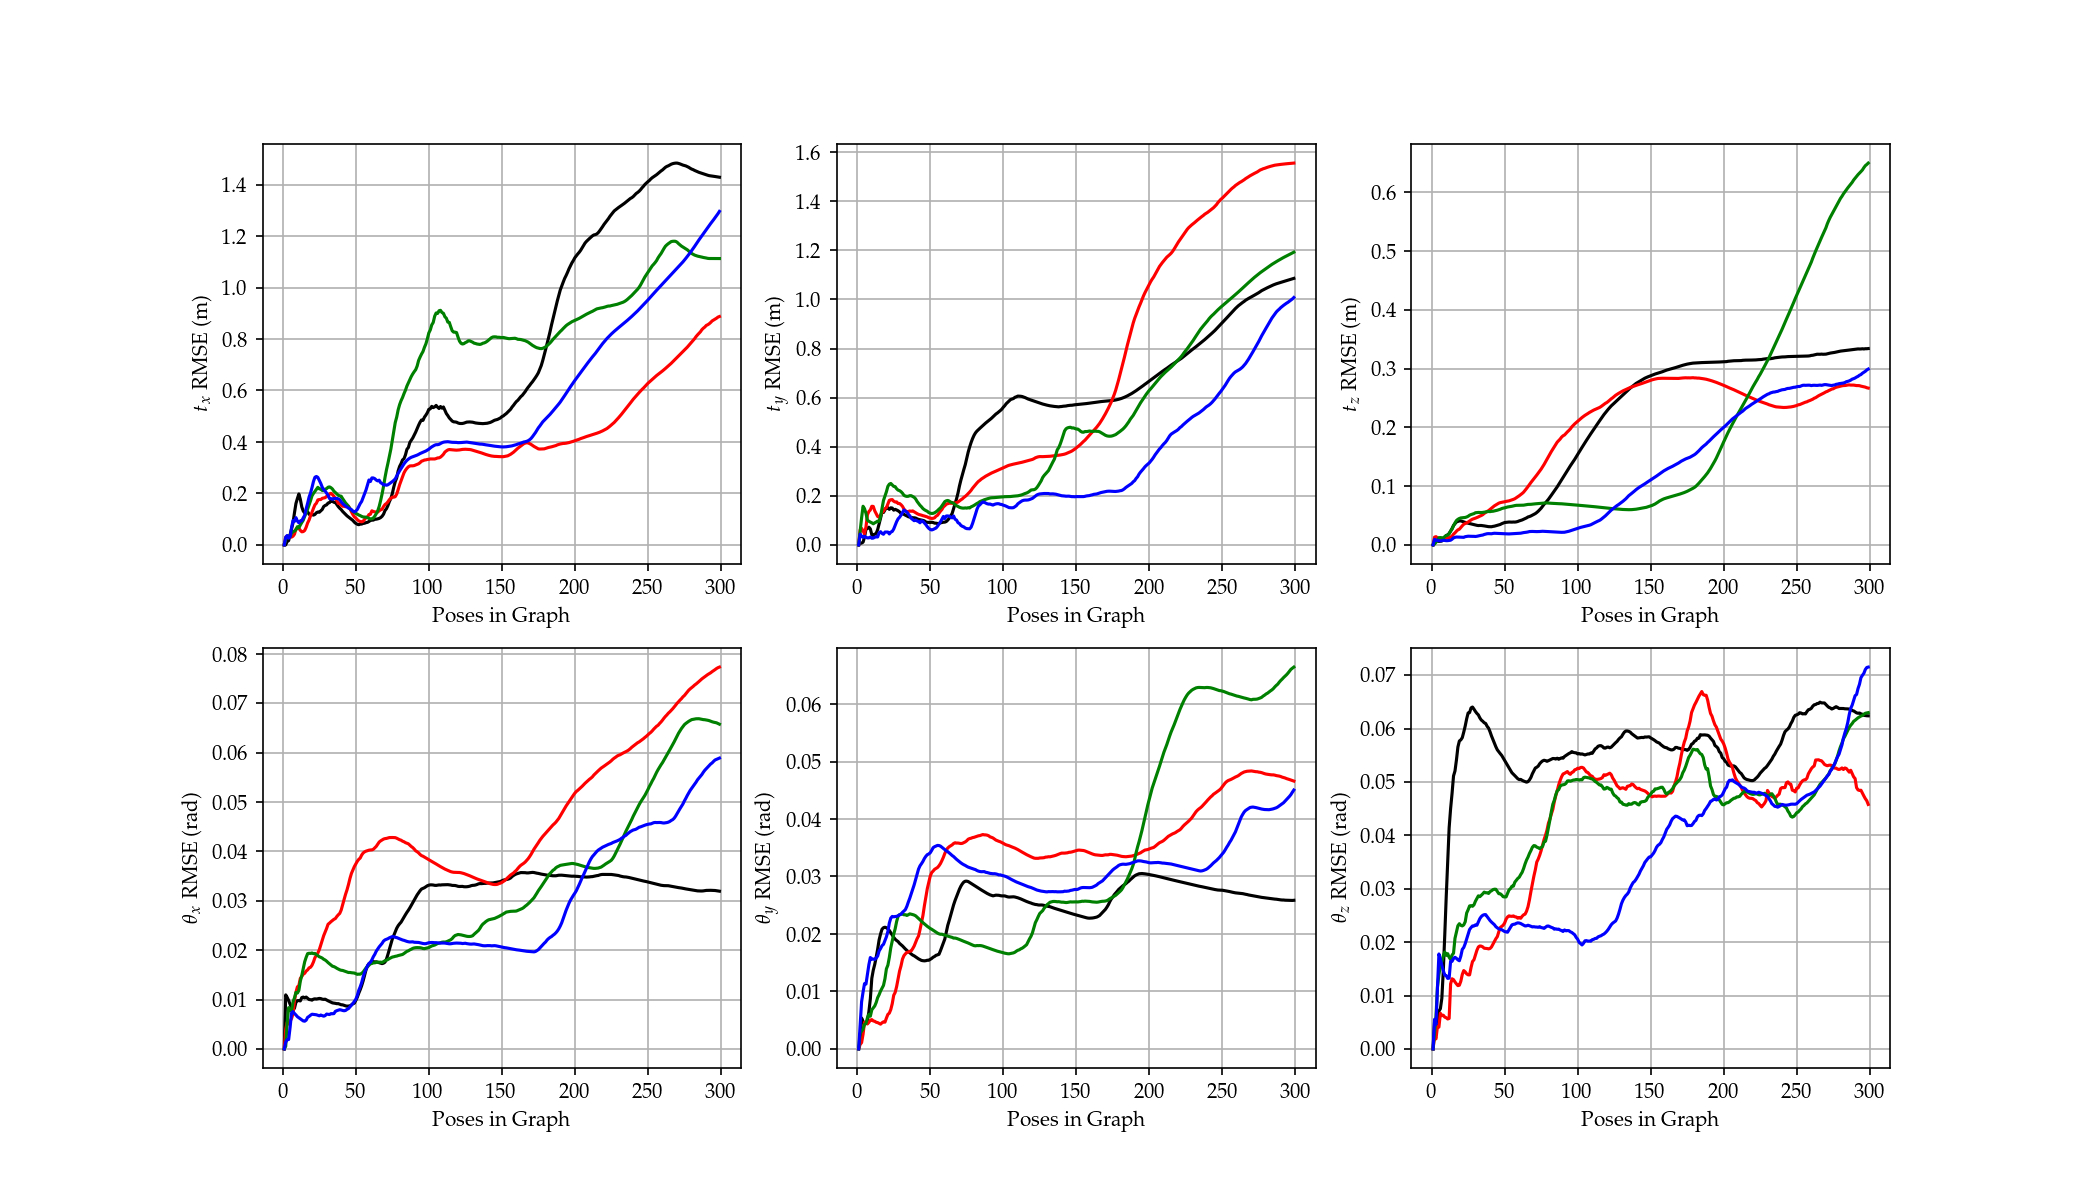

<IPython.core.display.Javascript object>


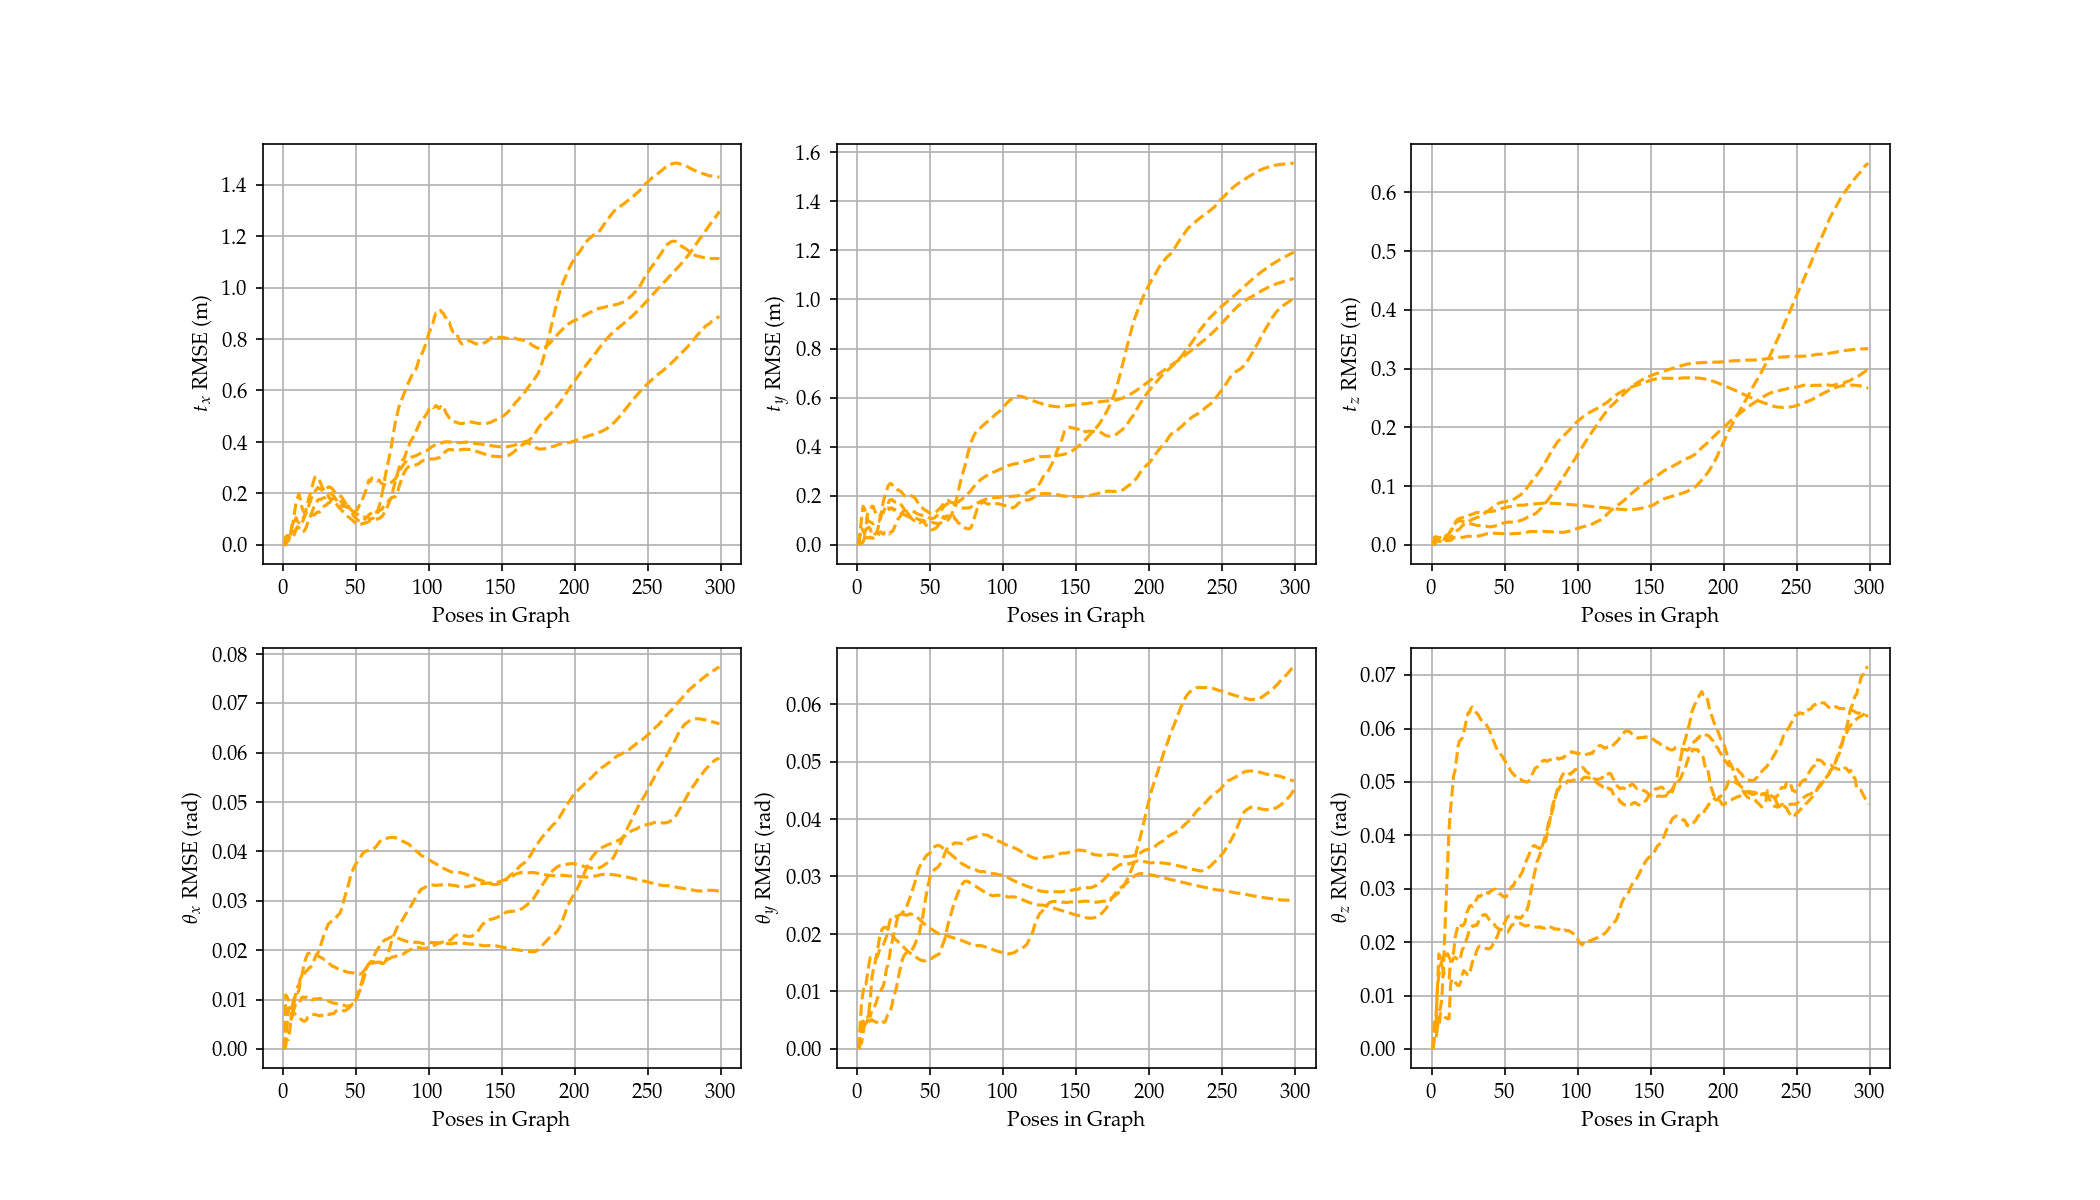

In [53]:
plotDRPGOResults('DRPGO/full_comm_no_anchor.csv','dd_full_comm_no_anchor')

<IPython.core.display.Javascript object>


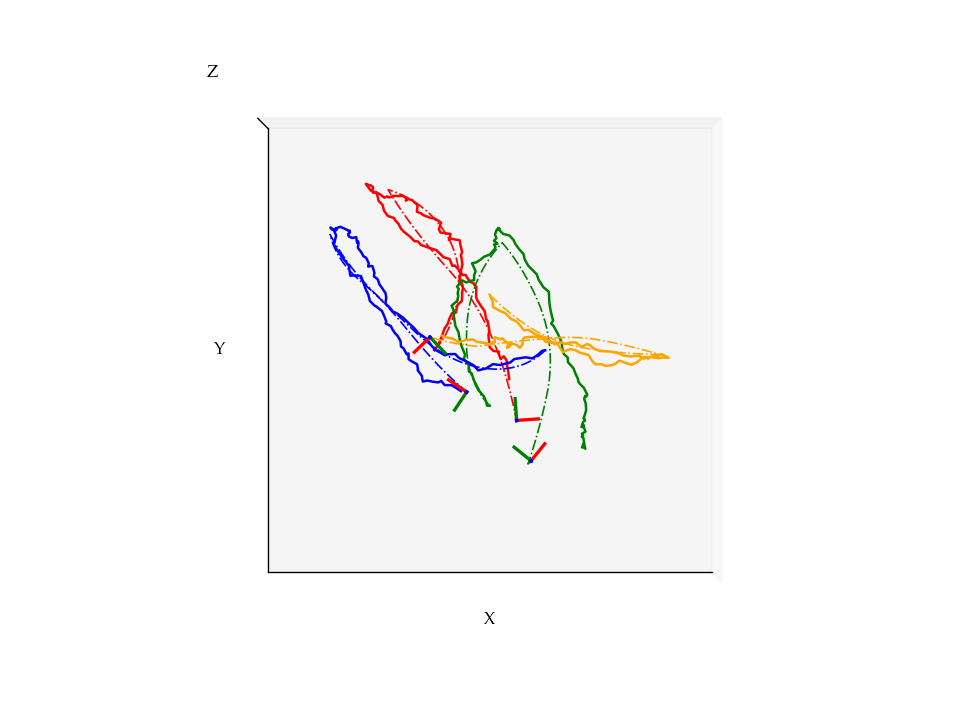

In [15]:
animator = animateDRPGOResults('DRPGO/no_comm.csv', 
                               title='Vanilla', 
                               cam_azimuth_deg=90, 
                               cam_elevation_deg=90, 
                               vidfile=None);

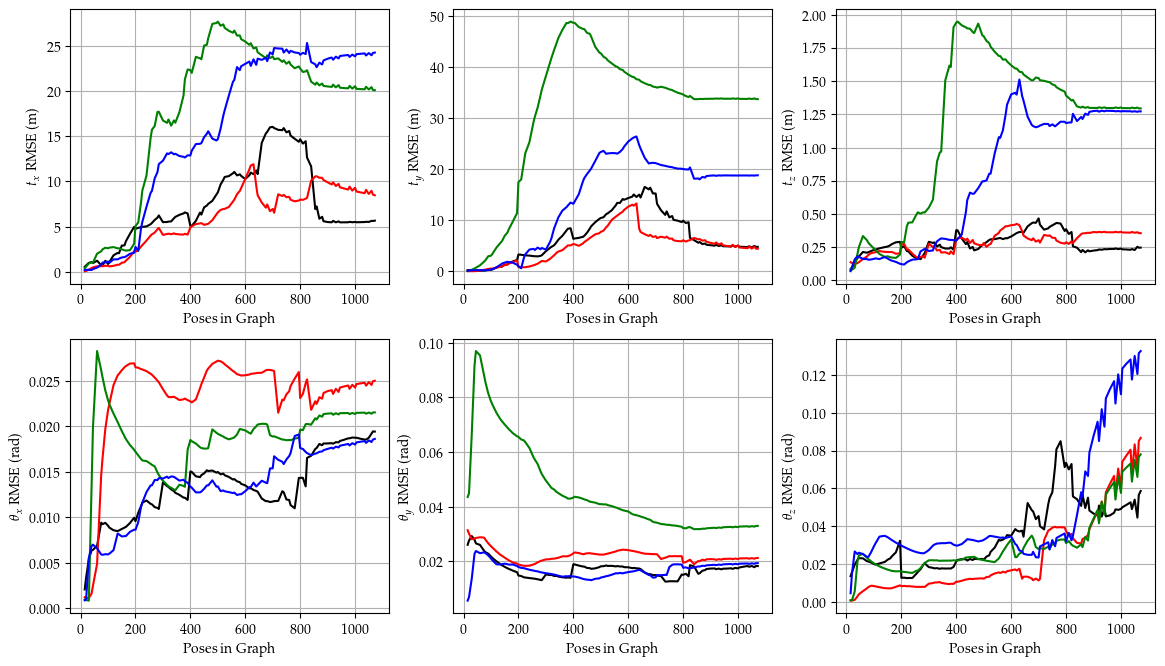

In [32]:
plot_RMSE_over_time('africa', 'rmse_allsensors.svg')